Задача - создать модель, которая будет предсказывать стоимость автомобиля в Самарской области по его характеристикам. Данные для обучения были получены с объявлений сайта Авито с помощью парсинга (ноутбук `parsing.ipynb`)

In [772]:
# импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [773]:
# считываем данные
data = pd.read_csv('../data/cars_data.csv', index_col=0)

data.sample(n=5)

,id,mark,name,price,params
14251,i3842613255,Skoda,"Skoda Octavia 1.4 AMT, 2019, 107 000 км",2050000,"107 000 км, 1.4 AMT (150 л.с.), лифтбек, перед..."
16529,i4230265771,Volkswagen,"Volkswagen Pointer 1.0 MT, 2004, 158 000 км",320000,"158 000 км, 1 MT (67 л.с.), хетчбэк, передний,..."
12547,i3982089635,Peugeot,"Peugeot 308 1.6 AT, 2010, 120 000 км",482200,"120 000 км, 1.6 AT (120 л.с.), хетчбэк, передн..."
7618,i4155709317,Kia,"Kia Rio 1.6 AT, 2019, 39 000 км",1510000,"39 000 км, 1.6 AT (123 л.с.), седан, передний,..."
11095,i4498236640,Mitsubishi,"Mitsubishi Outlander 2.0 CVT, 2012, 238 001 км",1250000,"238 001 км, 2 CVT (146 л.с.), внедорожник, пол..."


In [774]:
# удалим дубликаты и признак id
data.drop_duplicates(keep='first', inplace=True)
data.drop(columns='id', inplace=True)

#  посмотрим размерность
data.shape

(18994, 4)

In [775]:
# посмотрим на краткое описание данных
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18994 entries, 0 to 23432
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   mark    18994 non-null  object
 1   name    18994 non-null  object
 2   price   18994 non-null  int64 
 3   params  18994 non-null  object
dtypes: int64(1), object(3)
memory usage: 742.0+ KB


### Обработка данных

In [776]:
# пропущенных значений нет
# начнем обработку признаков
data.sample(n=5)

,mark,name,price,params
3919,Geely,"Geely Monjaro 2.0 AT, 2023, 147 км",3530000,"147 км, 2.0 AT (238 л.с.), внедорожник, полный..."
4126,Geely,"Geely Atlas 2.0 MT, 2020, 97 885 км",1790000,"97 885 км, 2.0 MT (141 л.с.), внедорожник, пер..."
12736,Peugeot,"Peugeot Partner 1.6 MT, 2003, 389 606 км",370000,"389 606 км, 1.6 MT (109 л.с.), минивэн, передн..."
1601,Chery,"Chery Tiggo 7 Pro 1.5 CVT, 2022, 35 000 км",2500000,"35 000 км, 1.5 CVT (147 л.с.), внедорожник, пе..."
22764,ГАЗ,"ГАЗ Соболь 2752 2.3 MT, 2000, 1 000 км",205000,"1 000 км, 2.3 MT (110 л.с.), фургон, задний, б..."


In [777]:
# В датасете есть новые автомобили (те, у которых пробег не указан), 
# их учитывать не нужно. Удалим такие записи 
data['name'] = data['name'].apply(lambda x: x if 'км' in x else None)
data.dropna(inplace=True)
data.shape

(17113, 4)

In [778]:
# из колонки name вытащим информацию,
# сколько лет автомобиль находится в эксплуатации
data['лет в эксплуатации'] = 2025 - data['name'].apply(lambda x: x.split(', ')[1]).apply(int)

In [779]:
# в датасете присутствуют битые авто
# cделаем отдельный признак
data['битый'] = data['name'].apply(lambda x: True if 'битый' in x else False)

In [780]:
# в признаке name оставим только название модели
data['модель'] = data['name'].apply(lambda x: ' '.join(x.split(', ')[0].split()[:-2]))
data.drop(columns='name', inplace=True)

In [781]:
# вытащим из params пробег
# сначала уберем пометку "Битый" у соответствующих машин
data['params'] = data['params'].apply(
    lambda x: x.replace("Битый, ", "") if "Битый" in x else x)

data['пробег'] = data['params'].apply(lambda x: x.split(', ')[0].replace('км', '').replace(' ', ''))

In [782]:
# проверим, что у всех авто в столбце params 5 блоков с информацией: 
# пробег, модификация, тип кузова, привод, тип топлива
data['params'].apply(lambda x: len(x.split(', '))).value_counts()

params
5    17082
4       31
Name: count, dtype: int64

In [783]:
# удалим некорректные записи
data['params'] = data['params'].apply(lambda x: x if len(x.split(', ')) == 5 else None)
data.dropna(inplace=True)

In [784]:
# создадим новые признаки - модификация, тип кузова, привод, тип топлива
data['модификация'] = data['params'].apply(lambda x: x.split(', ')[1])
data['тип кузова'] = data['params'].apply(lambda x: x.split(', ')[2])
data['привод'] = data['params'].apply(lambda x: x.split(', ')[3])
data['тип топлива'] = data['params'].apply(lambda x: x.split(', ')[4])

# удалим лишний теперь столбец params
data.drop(columns='params', inplace=True)

In [785]:
# из модификации достанем объем двигателя, тип трансмиссии и мощность

# Автомобили с электрическим типом двигателя не могут иметь такую характеристику, 
# так как у них в принципе отсутствует камера сгорания топлива, по которой считается объем. 
# Тогда можно сказать, что у электромобилей объем двигателя - 0 л и модель не будет учитывать данный признак
data.loc[data['тип топлива'] == 'электро', 'модификация'] = data[data['тип топлива'] == 'электро']['модификация'].apply(
    lambda x: '0 ' + x)

# создадим новые признаки
data['объём двигателя'] = data['модификация'].apply(lambda x: x.split()[0])
data['тип трансмиссии'] = data['модификация'].apply(lambda x: x.split()[1])
data['мощность'] = data['модификация'].apply(lambda x: x.split('(')[-1].split()[0])

# удалим ненужный
data.drop(columns='модификация', inplace=True)

In [786]:
# переименуем столбцы 
data.rename(columns={'mark': 'марка', 'price': 'цена'}, inplace=True)

In [787]:
# посмотрим на обработанный датасет
data.sample(n=5)

,марка,цена,лет в эксплуатации,битый,модель,пробег,тип кузова,привод,тип топлива,объём двигателя,тип трансмиссии,мощность
3511,Ford,750000,14,False,Ford Mondeo,274000,седан,передний,бензин,1.6,MT,120
5694,Hyundai,1699000,7,False,Hyundai Creta,103320,внедорожник,передний,бензин,1.6,MT,123
21927,ВАЗ (LADA),761000,6,False,ВАЗ (LADA) 4x4 (Нива),78400,внедорожник,полный,бензин,1.7,MT,83
20022,ВАЗ (LADA),499000,10,False,ВАЗ (LADA) Kalina,166000,универсал,передний,бензин,1.6,MT,106
7198,Hyundai,420000,18,False,Hyundai Matrix,286810,минивэн,передний,бензин,1.6,MT,103


In [788]:
# посмотрим на типы колонок
data.dtypes

марка                 object
цена                   int64
лет в эксплуатации     int64
битый                   bool
модель                object
пробег                object
тип кузова            object
привод                object
тип топлива           object
объём двигателя       object
тип трансмиссии       object
мощность              object
dtype: object

In [789]:
# приведем колонки Пробег, Объём двигателя и Мощность к числовому типу
cols_to_num = ['пробег', 'объём двигателя', 'мощность']
data[cols_to_num] = data[cols_to_num].map(pd.to_numeric)

### EDA

In [790]:
# посмотрим на вещественные колонки
num_cols = ['цена', 'лет в эксплуатации', 'пробег', 'объём двигателя', 'мощность']

# изучим их
data[num_cols].describe()

,цена,лет в эксплуатации,пробег,объём двигателя,мощность
count,1.708200e+04,17082.000000,17082.000000,17082.000000,17082.000000
mean,1.612781e+06,11.458963,145012.917047,1.944603,139.117258
std,1.805403e+06,6.978878,92524.202288,0.634983,59.144335
min,2.255500e+04,1.000000,1.000000,0.000000,20.000000
25%,6.500000e+05,6.000000,80000.000000,1.600000,105.000000
50%,1.143000e+06,11.000000,137000.000000,1.600000,123.000000
75%,1.940000e+06,15.000000,196102.250000,2.000000,150.000000
max,3.450000e+07,103.000000,1000000.000000,6.200000,625.000000


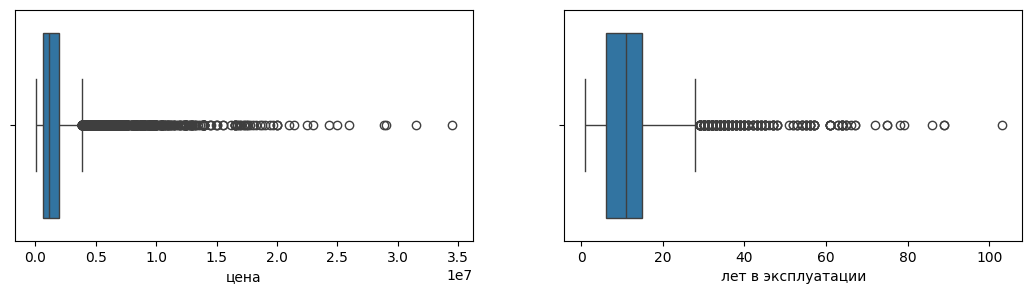

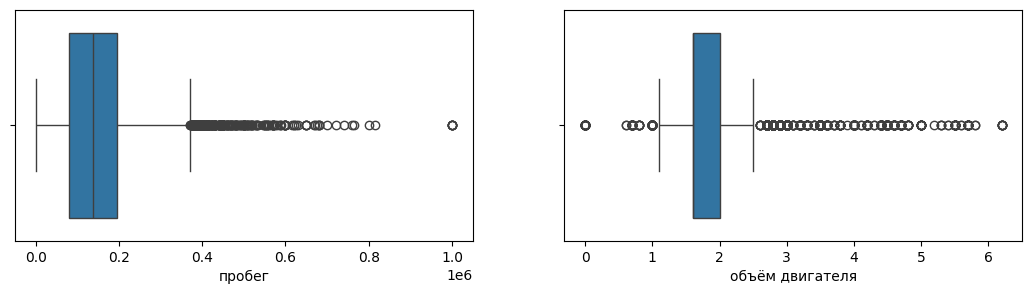

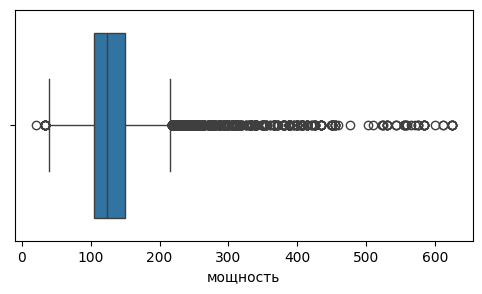

In [791]:
# нарисуем боксплоты для вещественных признаков
i=0
while i < 5:
    fig = plt.figure(figsize=[13,3])

    plt.subplot(1,2,1)
    sns.boxplot(x=num_cols[i], data=data)
    i += 1
    
    if i == 5: break
    plt.subplot(1,2,2)
    sns.boxplot(x=num_cols[i], data=data)
    i += 1
    
    plt.show()

In [792]:
# уберем самые сильные выбросы
data = data[(data['лет в эксплуатации'] <= 80) | (data['пробег'] <= 800000)]

In [793]:
# посмотрим на категориальные колонки
categorical_columns = data.loc[:,data.dtypes==object].columns

# изучим их
data.describe(include='object')

,марка,модель,тип кузова,привод,тип топлива,тип трансмиссии
count,17082,17082,17082,17082,17082,17082
unique,28,738,11,3,5,4
top,ВАЗ (LADA),ВАЗ (LADA) Granta,внедорожник,передний,бензин,MT
freq,2379,571,6252,10337,15066,8034


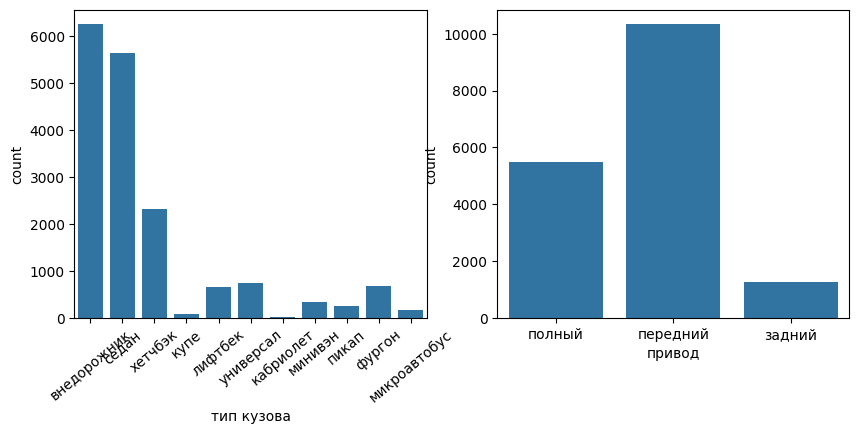

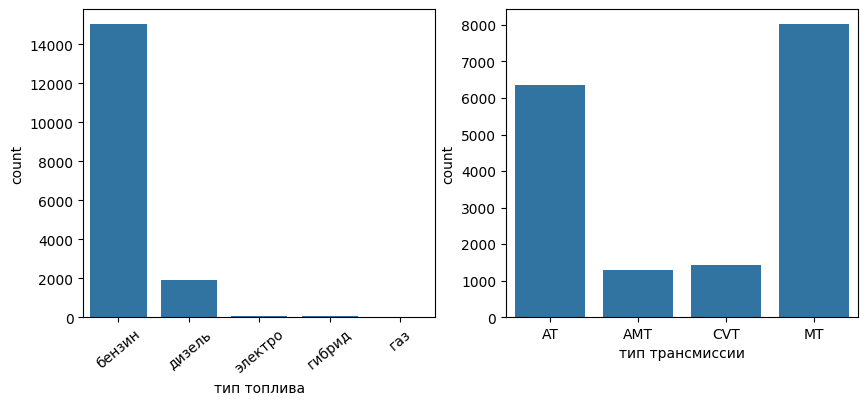

In [794]:
# посмотрим на распределение некоторых категориальных признаков
cat_cols = ['тип кузова','привод', 'тип топлива','тип трансмиссии']
i=0
while i < 4:
    fig = plt.figure(figsize=[10,4])
    
    plt.subplot(1,2,1)
    sns.countplot(x=cat_cols[i], data=data)
    i += 1
    
    plt.xticks(rotation=40)

    plt.subplot(1,2,2)
    sns.countplot(x=cat_cols[i], data=data)
    i += 1
    
    plt.show()

In [795]:
# перед кодированием признаков переименуем колонки и значения тех признаков,
# которые будут закодированы с помощью one hot (количество уникальных значений <= 5)

# переименовываем столбцы
data.rename(columns={
    'марка': 'brand',
    'цена': 'price',
    'лет в эксплуатации': 'years_in_operation',
    'битый': 'is_crashed',
    'модель': 'model',
    'пробег': 'mileage',
    'тип кузова': 'body_type',
    'привод': 'drive_type',
    'тип топлива': 'fuel_type',
    'объём двигателя': 'engine_volume',
    'тип трансмиссии': 'transmission_type',
    'мощность': 'power'
}, inplace=True)

In [796]:
# посмотрим на данные
# новые объекты будут поступать в таком формате 
data.sample(n=5)

,brand,price,years_in_operation,is_crashed,model,mileage,body_type,drive_type,fuel_type,engine_volume,transmission_type,power
12586,Peugeot,570000,15,False,Peugeot 308,280000,хетчбэк,передний,бензин,1.6,MT,120
1856,Chevrolet,255000,17,False,Chevrolet Aveo,268000,седан,передний,бензин,1.2,MT,72
2545,Chevrolet,650000,10,False,Chevrolet Niva,250000,внедорожник,полный,бензин,1.7,MT,80
8825,Kia,1139000,9,False,Kia Rio,145601,седан,передний,бензин,1.6,AT,123
16460,Volkswagen,650000,17,False,Volkswagen Jetta,228919,седан,передний,бензин,1.6,AT,102


In [797]:
# сохраним несколько примеров для тестирования модели 
data.sample(n=30).to_csv('test.csv')

In [798]:
# переименуем значения столбцов Привод (drive_type) и Тип топлива (fuel_type)
# значения столбца Тип трансмиссии (transmission_type) уже на английском, их переименовывать не нужно
print(data['drive_type'].unique())
print(data['fuel_type'].unique())

['полный' 'передний' 'задний']
['бензин' 'дизель' 'электро' 'гибрид' 'газ']


In [799]:
# переименовываем значения, чтобы новые столбцы, полученные с помощью one hot
# были написаны на одном языке - английском
rename_dict = {'полный': 'all', 'передний': 'front', 'задний': 'rear',
               'бензин': 'gasoline', 'дизель': 'diesel', 'электро': 'electric', 
               'гибрид': 'hybrid', 'газ': 'gas'}

data['drive_type'] = data['drive_type'].apply(lambda x: rename_dict[x])
data['fuel_type'] = data['fuel_type'].apply(lambda x: rename_dict[x])

# сохраним словарь
import pickle

file_path = '../utils/rename_dict.pkl'
pickle.dump(rename_dict, open(file_path, 'wb'))

In [800]:
# закодируем категориальные колонки
# данные для декодирования новых объектов
from sklearn.preprocessing import OneHotEncoder

# сбросим индексы
data.reset_index(drop=True, inplace=True)

categorical_columns = data.loc[:,data.dtypes==object].columns

for col in categorical_columns:
    if data[col].nunique() <= 5:
        encoder = OneHotEncoder(drop='first')
        encoder.fit(data[[col]])

        file_path = f'../utils/{col}_one_hot.pkl'
        pickle.dump(encoder, open(file_path, 'wb'))

        encoded_col = encoder.transform(data[[col]])
        encoded_col_df = pd.DataFrame(encoded_col.toarray(), columns=encoder.get_feature_names_out([col]))
        data = pd.concat((data.drop(col, axis=1), encoded_col_df), axis=1)
    else:
        median_target = data.groupby(col)['price'].median()

        file_path = f'../utils/{col}_target.pkl'
        pickle.dump(median_target, open(file_path, 'wb'))

        data[col] = data[col].map(median_target)

In [801]:
# посмотрим на получившийся датасет
data.sample(n=5)

,brand,price,years_in_operation,is_crashed,model,mileage,body_type,engine_volume,power,drive_type_front,drive_type_rear,fuel_type_electric,fuel_type_gas,fuel_type_gasoline,fuel_type_hybrid,transmission_type_AT,transmission_type_CVT,transmission_type_MT
14013,556600.0,699900,3,False,659000.0,85000,865000.0,1.6,90,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2485,810000.0,490000,17,False,749500.0,300000,865000.0,1.8,125,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2184,649500.0,430000,17,False,610000.0,152500,1849995.0,1.7,80,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
595,2450000.0,2650000,11,False,2650000.0,80000,1597500.0,2.0,184,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
6314,1505000.0,2114600,6,False,1349000.0,92042,865000.0,2.0,150,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


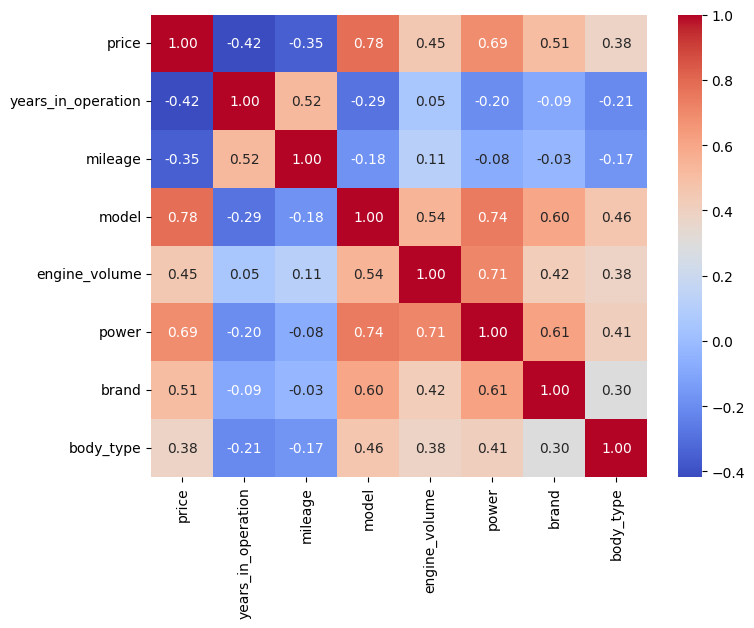

In [803]:
# посмотрим матрицу корреляций
corr_matrix = data[['price', 'years_in_operation', 'mileage', 'model',
                    'engine_volume', 'power', 'brand', 'body_type']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.show()

### Обучение модели

In [804]:
# разделим и нормализуем выборку
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

X = data.drop(columns='price')
y = data['price']

scaler = MinMaxScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [805]:
# напишем функцию для вывода и сохранения метрик модели
from sklearn.metrics import mean_absolute_error, r2_score, mean_absolute_percentage_error 

MAE_train = []
MAE_test = []
R2_train = []
R2_test = []
MAPE_train = []
MAPE_test = []

def car_pred_model(model):
    model.fit(X_train, y_train)
            
    y_pred_train = model.predict(X_train)
    MAE_train_model = mean_absolute_error(y_train, y_pred_train)
    R2_train_model = r2_score(y_train, y_pred_train)
    MAPE_train_model = mean_absolute_percentage_error(y_train, y_pred_train)
    MAE_train.append(round(MAE_train_model, 3))
    R2_train.append(round(R2_train_model, 3))
    MAPE_train.append(round(MAPE_train_model, 3))
    
    y_pred_test = model.predict(X_test)
    MAE_test_model = mean_absolute_error(y_test, y_pred_test)
    R2_test_model = r2_score(y_test, y_pred_test)
    MAPE_test_model = mean_absolute_percentage_error(y_test, y_pred_test)
    MAE_test.append(round(MAE_test_model, 3))
    R2_test.append(round(R2_test_model, 3))
    MAPE_test.append(round(MAPE_test_model, 3))
    
    print("Train MAE:",round(MAE_train_model, 3))
    print("Test MAE:",round(MAE_test_model, 3))
    print("Train R2-score:",round(R2_train_model, 3))
    print("Test R2-score:",round(R2_test_model, 3))
    print("Train MAPE:",round(MAPE_train_model, 3))
    print("Test MAPE:",round(MAPE_test_model, 3))

In [806]:
# построим линейную регрессию
from sklearn.linear_model import LinearRegression

linear_regression = LinearRegression()
car_pred_model(linear_regression)

Train MAE: 482505.968
Test MAE: 459621.54
Train R2-score: 0.722
Test R2-score: 0.703
Train MAPE: 0.526
Test MAPE: 0.511


In [807]:
# попробуем с L1 регуляризацией
from sklearn.linear_model import Lasso
from sklearn.model_selection import RandomizedSearchCV

lasso = Lasso()

alpha = np.logspace(-4, 2, num=10)

lasso_rs = RandomizedSearchCV(lasso, param_distributions=dict(alpha=alpha))

car_pred_model(lasso_rs)

Train MAE: 481823.981
Test MAE: 459078.962
Train R2-score: 0.722
Test R2-score: 0.703
Train MAPE: 0.525
Test MAPE: 0.51


In [808]:
# попробуем с L2 регуляризацией
from sklearn.linear_model import Ridge
from sklearn.model_selection import RandomizedSearchCV

ridge = Ridge()

alpha = np.logspace(-3, 1, num=10)

ridge_rs = RandomizedSearchCV(ridge, param_distributions = dict(alpha=alpha))

car_pred_model(ridge_rs)

Train MAE: 482327.123
Test MAE: 459423.701
Train R2-score: 0.722
Test R2-score: 0.703
Train MAPE: 0.526
Test MAPE: 0.511


In [809]:
# построим knn модель
from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor()

param_grid = {
    'n_neighbors': [  1,  25,  50,  75, 100],
    'p': [1, 3, 5],
    'weights': ['uniform', 'distance']
}

knn_rs = RandomizedSearchCV(knn, param_distributions=param_grid)

car_pred_model(knn_rs)

Train MAE: 1825.338
Test MAE: 250180.019
Train R2-score: 1.0
Test R2-score: 0.87
Train MAPE: 0.001
Test MAPE: 0.229


In [810]:
# построим случайный лес
from sklearn.ensemble import RandomForestRegressor

random_forest = RandomForestRegressor()

param_grid = {"n_estimators": [500, 600, 700, 800, 900],
              "max_depth": [2, 4, 8],
              "min_samples_split": [4, 6, 8],
              "min_samples_leaf": [1, 2, 5, 7]}

random_forest_rs = RandomizedSearchCV(
    random_forest, param_distributions=param_grid)

car_pred_model(random_forest_rs)

Train MAE: 245975.87
Test MAE: 258374.655
Train R2-score: 0.923
Test R2-score: 0.894
Train MAPE: 0.209
Test MAPE: 0.225


In [811]:
# построим градиентный бустинг
from catboost import CatBoostRegressor

cat_boost = CatBoostRegressor(silent=True)

param_grid = {
    'iterations': [200, 250, 300, 350, 400],
    'learning_rate': [0.1, 0.5, 1],
    'depth': [4, 6, 7, 8],
    'l2_leaf_reg': [0, 1e-4, 0.1, 1],
}

cat_boost_rs = RandomizedSearchCV(cat_boost, param_distributions=param_grid)

car_pred_model(cat_boost_rs)

Train MAE: 157037.024
Test MAE: 195327.843
Train R2-score: 0.983
Test R2-score: 0.941
Train MAPE: 0.152
Test MAPE: 0.171


In [812]:
# посмотрим на качество моделей
models = ["LinearRegression", "Ridge", "Lasso",
          "KNN", "RandomForestRegressor", "CatBoostRegressor"]
results = pd.DataFrame({'Model': models, 'MAE(Test)': MAE_test,
                        'R Squared(Test)': R2_test,
                        'MAPE(Test)': MAPE_test})
results

,Model,MAE(Test),R Squared(Test),MAPE(Test)
0,LinearRegression,459621.540,0.703,0.511
1,Ridge,459078.962,0.703,0.510
2,Lasso,459423.701,0.703,0.511
3,KNN,250180.019,0.870,0.229
4,RandomForestRegressor,258374.655,0.894,0.225
5,CatBoostRegressor,195327.843,0.941,0.171


In [813]:
best_model = cat_boost_rs.best_estimator_

file_path_model = '../utils/catboost_model.pkl'
file_path_scaler = '../utils/scaler.pkl'
pickle.dump(best_model, open(file_path_model, 'wb'))
pickle.dump(scaler, open(file_path_scaler, 'wb'))

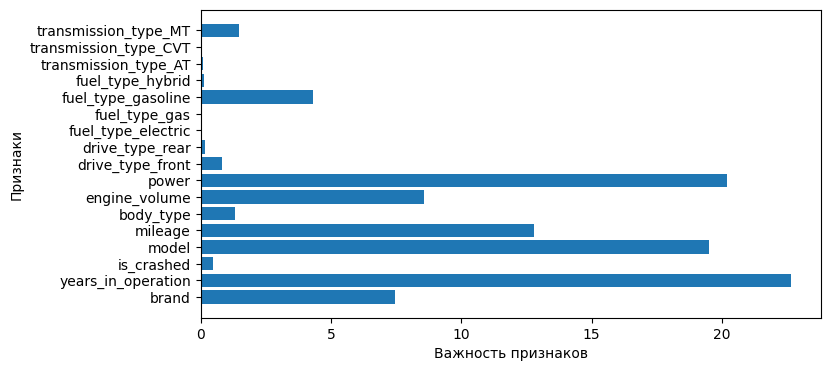

In [814]:
# посмотрим на важность признаков
feature_importance = best_model.get_feature_importance(type='FeatureImportance')
feature_names = data.drop(columns='price').columns  

plt.figure(figsize=(8, 4))
plt.barh(range(len(feature_importance)), feature_importance, align='center')
plt.yticks(range(len(feature_importance)), feature_names)
plt.xlabel('Важность признаков')
plt.ylabel('Признаки')
plt.show()